In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/herwill-datathon-2022/weather_description.pdf
/kaggle/input/herwill-datathon-2022/2017-04_1H_zone.csv
/kaggle/input/herwill-datathon-2022/2017-02_1H_zone.csv
/kaggle/input/herwill-datathon-2022/weather.csv
/kaggle/input/herwill-datathon-2022/2017-01_1H_zone.csv
/kaggle/input/herwill-datathon-2022/zone_neighbors.json
/kaggle/input/herwill-datathon-2022/2017-05_1H_zone.csv
/kaggle/input/herwill-datathon-2022/test_pred.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/herwill-datathon-2022/2017-03_1H_zone.csv
/kaggle/input/herwill-datathon-2022/test_df_encrypted.csv
/kaggle/input/herwill-datathon-2022/test_weather_encrypted.csv


In [2]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
!pip install scikit-uplift -q
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels
import xgboost as xgb

In [3]:
#train = pd.read_csv('/kaggle/input/herwill-datathon-2022/2017-05_1H_zone.csv')

In [4]:
df_1=pd.read_csv('/kaggle/input/herwill-datathon-2022/2017-01_1H_zone.csv')
df_2=pd.read_csv('/kaggle/input/herwill-datathon-2022/2017-02_1H_zone.csv')
df_3=pd.read_csv('/kaggle/input/herwill-datathon-2022/2017-03_1H_zone.csv')
df_4=pd.read_csv('/kaggle/input/herwill-datathon-2022/2017-04_1H_zone.csv')
df_5=pd.read_csv('/kaggle/input/herwill-datathon-2022/2017-05_1H_zone.csv')
df_we=pd.read_csv('/kaggle/input/herwill-datathon-2022/weather.csv')

In [5]:
main_df = pd.concat([df_1,df_2,df_4,df_5],ignore_index=True)

In [6]:
main_df.head(10)

,Unnamed: 0,PUZone,Count,PUTime
0,0,0,91,2017-01-01 00:00:00
1,1,1,582,2017-01-01 00:00:00
2,2,2,292,2017-01-01 00:00:00
3,3,3,376,2017-01-01 00:00:00
4,4,4,67,2017-01-01 00:00:00
5,5,5,9,2017-01-01 00:00:00
6,6,6,3,2017-01-01 00:00:00
7,7,7,0,2017-01-01 00:00:00
8,8,8,84,2017-01-01 00:00:00
9,9,9,11,2017-01-01 00:00:00


In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210240 entries, 0 to 210239
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  210240 non-null  int64 
 1   PUZone      210240 non-null  int64 
 2   Count       210240 non-null  int64 
 3   PUTime      210240 non-null  object
dtypes: int64(3), object(1)
memory usage: 6.4+ MB


In [8]:
main_df.describe()

,Unnamed: 0,PUZone,Count
count,210240.000000,210240.000000,210240.000000
mean,26323.300000,36.000000,157.591824
std,15246.735939,21.071358,200.861502
min,0.000000,0.000000,0.000000
25%,13139.750000,18.000000,11.000000
50%,26279.500000,36.000000,68.000000
75%,39419.250000,54.000000,246.000000
max,54311.000000,72.000000,1915.000000


In [9]:
main_df.set_axis(['Id','PUZone','Count','PUTime'],axis=1,inplace=True)

In [10]:
main_df.columns

Index(['Id', 'PUZone', 'Count', 'PUTime'], dtype='object')

In [11]:
main_df['PUZone'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

In [12]:
main_df.isnull().sum()#have to do anything for null value?no

Id        0
PUZone    0
Count     0
PUTime    0
dtype: int64

In [13]:
print("Number of rows:",main_df.shape[0])
print("Number of columns:",main_df.shape[1])

Number of rows: 210240
Number of columns: 4


In [14]:
cols=['PUZone','PUTime']

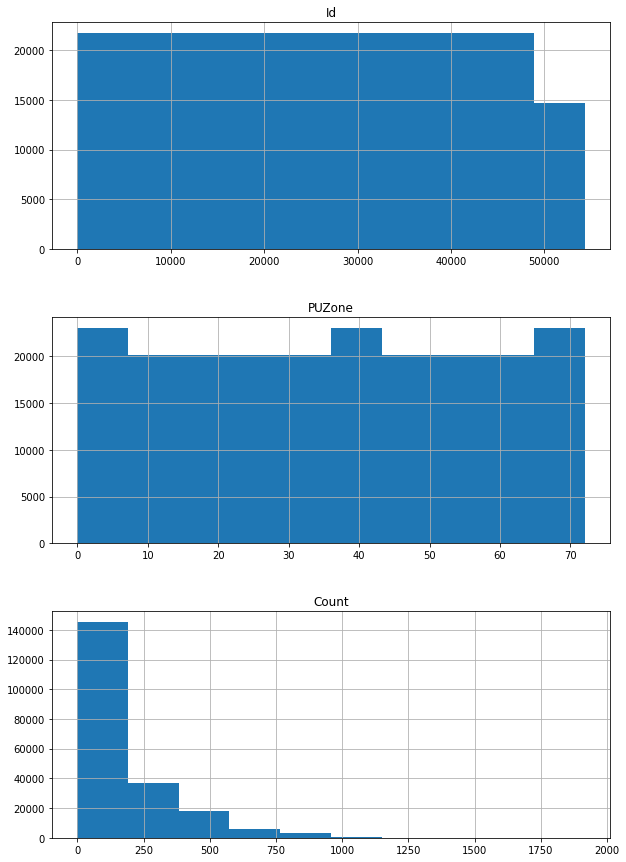

In [15]:
fig, axis = plt.subplots(3,1,figsize=(10, 15))
main_df.hist(ax=axis)
plt.show()

In [16]:
main1_df=main_df
main1_df.head(4)

,Id,PUZone,Count,PUTime
0,0,0,91,2017-01-01 00:00:00
1,1,1,582,2017-01-01 00:00:00
2,2,2,292,2017-01-01 00:00:00
3,3,3,376,2017-01-01 00:00:00


<AxesSubplot:>

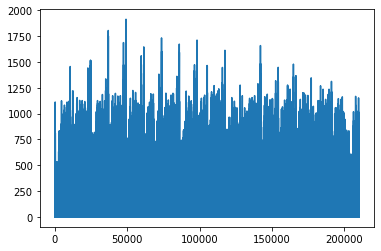

In [17]:
num= main1_df['Count']
num.plot()

<AxesSubplot:>

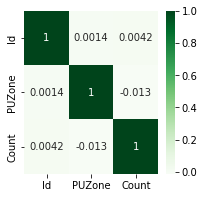

In [18]:
plt.figure(figsize=(3,3))
sns.heatmap(main_df.corr(),cmap='Greens',annot=True)

In [19]:
main2_df=main_df
main2_df

,Id,PUZone,Count,PUTime
0,0,0,91,2017-01-01 00:00:00
1,1,1,582,2017-01-01 00:00:00
2,2,2,292,2017-01-01 00:00:00
3,3,3,376,2017-01-01 00:00:00
4,4,4,67,2017-01-01 00:00:00
...,...,...,...,...
210235,54307,68,44,2017-05-31 23:00:00
210236,54308,69,459,2017-05-31 23:00:00
210237,54309,70,82,2017-05-31 23:00:00
210238,54310,71,34,2017-05-31 23:00:00


In [20]:
main2_df.columns

Index(['Id', 'PUZone', 'Count', 'PUTime'], dtype='object')

In [21]:
column_1 = main2_df.iloc[:,0]
column_1

0             0
1             1
2             2
3             3
4             4
          ...  
210235    54307
210236    54308
210237    54309
210238    54310
210239    54311
Name: Id, Length: 210240, dtype: int64

In [22]:
main2_df.dtypes

Id         int64
PUZone     int64
Count      int64
PUTime    object
dtype: object

In [23]:
main2_df['Date_Time'] = pd.to_datetime(main2_df['PUTime'], infer_datetime_format=True)

In [24]:
main2_df.head(1)

,Id,PUZone,Count,PUTime,Date_Time
0,0,0,91,2017-01-01 00:00:00,2017-01-01


In [25]:
pd.to_datetime(main2_df['Date_Time'],
               format= " %Y-%m-%d %H:%M:%S") 

0        2017-01-01 00:00:00
1        2017-01-01 00:00:00
2        2017-01-01 00:00:00
3        2017-01-01 00:00:00
4        2017-01-01 00:00:00
                 ...        
210235   2017-05-31 23:00:00
210236   2017-05-31 23:00:00
210237   2017-05-31 23:00:00
210238   2017-05-31 23:00:00
210239   2017-05-31 23:00:00
Name: Date_Time, Length: 210240, dtype: datetime64[ns]

In [26]:
column_1 = main2_df['Date_Time']

pd.DataFrame({"year": column_1.dt.year,
              "month": column_1.dt.month,
              "day": column_1.dt.day,
              "hour": column_1.dt.hour,
              "dayofyear": column_1.dt.dayofyear,
              "week": column_1.dt.week,
              "weekofyear": column_1.dt.weekofyear,
              "dayofweek": column_1.dt.dayofweek,
              "weekday": column_1.dt.weekday,
              "quarter": column_1.dt.quarter,
             })

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


,year,month,day,hour,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,2017,1,1,0,1,52,52,6,6,1
1,2017,1,1,0,1,52,52,6,6,1
2,2017,1,1,0,1,52,52,6,6,1
3,2017,1,1,0,1,52,52,6,6,1
4,2017,1,1,0,1,52,52,6,6,1
...,...,...,...,...,...,...,...,...,...,...
210235,2017,5,31,23,151,22,22,2,2,2
210236,2017,5,31,23,151,22,22,2,2,2
210237,2017,5,31,23,151,22,22,2,2,2
210238,2017,5,31,23,151,22,22,2,2,2


In [27]:
#main2_df.head(2)

In [28]:
main3_df=main2_df
main3_df.head(5)

,Id,PUZone,Count,PUTime,Date_Time
0,0,0,91,2017-01-01 00:00:00,2017-01-01
1,1,1,582,2017-01-01 00:00:00,2017-01-01
2,2,2,292,2017-01-01 00:00:00,2017-01-01
3,3,3,376,2017-01-01 00:00:00,2017-01-01
4,4,4,67,2017-01-01 00:00:00,2017-01-01


In [29]:
 """days = main2_df['Date_Time'].dt.day
 months = main2_df['Date_Time'].dt.month
 hour = main2_df['Date_Time'].dt.hour
 main3_df = pd.DataFrame(zip(days,months,hour), columns = ['DAY','MONTH','Hour'])"""

"days = main2_df['Date_Time'].dt.day\nmonths = main2_df['Date_Time'].dt.month\nhour = main2_df['Date_Time'].dt.hour\nmain3_df = pd.DataFrame(zip(days,months,hour), columns = ['DAY','MONTH','Hour'])"

In [30]:
 main3_df['DAY'] = main3_df['Date_Time'].dt.day
 main3_df['MONTH'] = main3_df['Date_Time'].dt.month
 main3_df['HOUR'] = main3_df['Date_Time'].dt.hour

 main3_df.drop(columns=['Date_Time'], inplace=True)
 main3_df.head() 

,Id,PUZone,Count,PUTime,DAY,MONTH,HOUR
0,0,0,91,2017-01-01 00:00:00,1,1,0
1,1,1,582,2017-01-01 00:00:00,1,1,0
2,2,2,292,2017-01-01 00:00:00,1,1,0
3,3,3,376,2017-01-01 00:00:00,1,1,0
4,4,4,67,2017-01-01 00:00:00,1,1,0


In [31]:
main3_df=main3_df.drop(columns=['PUTime'])
main3_df.head(3)

,Id,PUZone,Count,DAY,MONTH,HOUR
0,0,0,91,1,1,0
1,1,1,582,1,1,0
2,2,2,292,1,1,0


In [32]:
main3_df['PUZone'].value_counts()

0     2880
37    2880
53    2880
52    2880
51    2880
      ... 
24    2880
23    2880
22    2880
21    2880
72    2880
Name: PUZone, Length: 73, dtype: int64

In [33]:
main3_df.drop_duplicates(inplace=True)
main3_df.head(2)

,Id,PUZone,Count,DAY,MONTH,HOUR
0,0,0,91,1,1,0
1,1,1,582,1,1,0


In [34]:
main3_df_show=main3_df.groupby(by='PUZone')['Count'].mean()
main3_df_show

PUZone
0     245.492708
1     304.213194
2     213.725694
3     176.585069
4      15.442708
         ...    
68     84.142014
69    366.032639
70     88.695139
71     45.979861
72    242.447569
Name: Count, Length: 73, dtype: float64

In [35]:
main3_df_show2=main3_df.groupby(by='DAY')['Count'].mean()
main3_df_show2

DAY
1     152.298231
2     146.782392
3     158.589897
4     165.339755
5     163.578910
6     166.310502
7     160.929795
8     156.093037
9     138.853311
10    156.121147
11    165.389269
12    161.518978
13    168.760274
14    159.980166
15    154.836901
16    149.890839
17    159.455194
18    161.338613
19    162.907392
20    160.321490
21    159.334475
22    153.408105
23    153.686358
24    161.096176
25    169.762414
26    157.760131
27    155.306079
28    156.772831
29    139.299467
30    143.971651
31    157.757420
Name: Count, dtype: float64

In [36]:
df_we1=pd.read_csv('/kaggle/input/herwill-datathon-2022/weather.csv')

In [37]:
df_we1.head(3)

,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,...,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08
0,1/1/17,5.59,NaN,0.00,0.0,0.0,NaN,48.0,40.0,NaN,...,310.0,15.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1/2/17,9.17,NaN,0.21,0.0,0.0,NaN,41.0,37.0,NaN,...,70.0,17.0,25.1,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2,1/3/17,10.74,NaN,0.58,0.0,0.0,NaN,43.0,39.0,NaN,...,60.0,21.0,30.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_we1= df_we1.fillna(value=df_we1.mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [39]:
df_we1.dropna()
df_we1.head(3)

,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,...,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08
0,1/1/17,5.59,NaN,0.00,0.0,0.0,NaN,48.0,40.0,NaN,...,310.0,15.0,23.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0
1,1/2/17,9.17,NaN,0.21,0.0,0.0,NaN,41.0,37.0,NaN,...,70.0,17.0,25.1,1.0,1.0,NaN,1.0,NaN,1.0,1.0
2,1/3/17,10.74,NaN,0.58,0.0,0.0,NaN,43.0,39.0,NaN,...,60.0,21.0,30.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0


In [40]:
df_we1.describe()

,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08
count,181.000000,0.0,181.000000,181.000000,181.000000,0.0,181.000000,181.000000,0.0,181.000000,181.000000,181.000000,181.000000,181.0,181.0,0.0,181.0,0.0,181.0,181.0
mean,6.382119,NaN,0.150861,0.178808,0.395364,NaN,54.298013,40.622517,NaN,197.152318,197.718121,15.796026,25.126174,1.0,1.0,NaN,1.0,NaN,1.0,1.0
std,2.288345,NaN,0.368901,0.984638,1.130454,NaN,13.390625,11.397242,NaN,93.650517,91.900434,3.918728,6.589161,0.0,0.0,NaN,0.0,NaN,0.0,0.0
min,2.240000,NaN,0.000000,0.000000,0.000000,NaN,23.000000,14.000000,NaN,20.000000,20.000000,6.900000,12.100000,1.0,1.0,NaN,1.0,NaN,1.0,1.0
25%,4.920000,NaN,0.000000,0.000000,0.000000,NaN,45.000000,35.000000,NaN,120.000000,150.000000,13.000000,21.000000,1.0,1.0,NaN,1.0,NaN,1.0,1.0
50%,6.382119,NaN,0.000000,0.000000,0.000000,NaN,54.298013,40.622517,NaN,197.152318,197.718121,15.796026,25.126174,1.0,1.0,NaN,1.0,NaN,1.0,1.0
75%,7.380000,NaN,0.150861,0.000000,0.395364,NaN,63.000000,48.000000,NaN,280.000000,280.000000,17.000000,28.000000,1.0,1.0,NaN,1.0,NaN,1.0,1.0
max,18.340000,NaN,3.020000,9.400000,7.900000,NaN,92.000000,75.000000,NaN,360.000000,340.000000,33.100000,48.100000,1.0,1.0,NaN,1.0,NaN,1.0,1.0


In [41]:
df_we1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    151 non-null    object 
 1   AWND    181 non-null    float64
 2   PGTM    0 non-null      float64
 3   PRCP    181 non-null    float64
 4   SNOW    181 non-null    float64
 5   SNWD    181 non-null    float64
 6   TAVG    0 non-null      float64
 7   TMAX    181 non-null    float64
 8   TMIN    181 non-null    float64
 9   TSUN    0 non-null      float64
 10  WDF2    181 non-null    float64
 11  WDF5    181 non-null    float64
 12  WSF2    181 non-null    float64
 13  WSF5    181 non-null    float64
 14  WT01    181 non-null    float64
 15  WT02    181 non-null    float64
 16  WT03    0 non-null      float64
 17  WT04    181 non-null    float64
 18  WT05    0 non-null      float64
 19  WT06    181 non-null    float64
 20  WT08    181 non-null    float64
dtypes: float64(20), object(1)
memory usage:

In [42]:
df_we1.isnull().sum()#have to do anything for null value?no

DATE     30
AWND      0
PGTM    181
PRCP      0
SNOW      0
SNWD      0
TAVG    181
TMAX      0
TMIN      0
TSUN    181
WDF2      0
WDF5      0
WSF2      0
WSF5      0
WT01      0
WT02      0
WT03    181
WT04      0
WT05    181
WT06      0
WT08      0
dtype: int64

In [43]:
df_we1=df_we1.drop(columns=['PGTM','TAVG','TSUN','WT03','WT05'])
df_we1.head(3)

,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT04,WT06,WT08
0,1/1/17,5.59,0.00,0.0,0.0,48.0,40.0,260.0,310.0,15.0,23.0,1.0,1.0,1.0,1.0,1.0
1,1/2/17,9.17,0.21,0.0,0.0,41.0,37.0,70.0,70.0,17.0,25.1,1.0,1.0,1.0,1.0,1.0
2,1/3/17,10.74,0.58,0.0,0.0,43.0,39.0,70.0,60.0,21.0,30.0,1.0,1.0,1.0,1.0,1.0


In [44]:
df_we1.dropna()
df_we1.head(3)

,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT04,WT06,WT08
0,1/1/17,5.59,0.00,0.0,0.0,48.0,40.0,260.0,310.0,15.0,23.0,1.0,1.0,1.0,1.0,1.0
1,1/2/17,9.17,0.21,0.0,0.0,41.0,37.0,70.0,70.0,17.0,25.1,1.0,1.0,1.0,1.0,1.0
2,1/3/17,10.74,0.58,0.0,0.0,43.0,39.0,70.0,60.0,21.0,30.0,1.0,1.0,1.0,1.0,1.0


In [45]:
df_we1.isnull().sum()#have to do anything for null value?no

DATE    30
AWND     0
PRCP     0
SNOW     0
SNWD     0
TMAX     0
TMIN     0
WDF2     0
WDF5     0
WSF2     0
WSF5     0
WT01     0
WT02     0
WT04     0
WT06     0
WT08     0
dtype: int64

<AxesSubplot:>

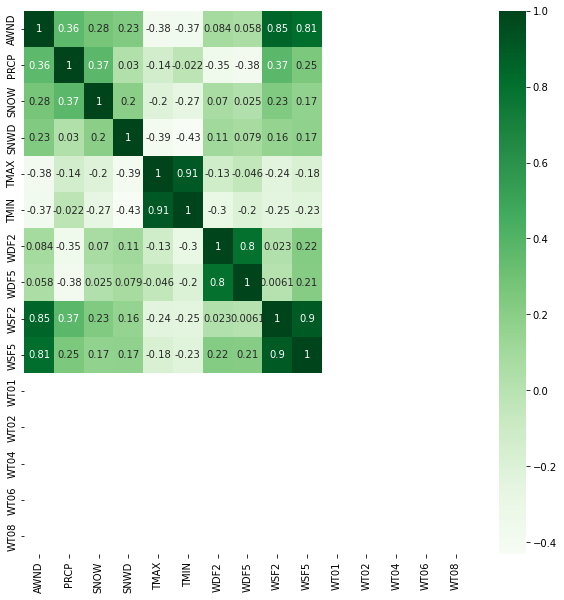

In [46]:
plt.figure(figsize=(10,10))
sns.heatmap(df_we1.corr(),cmap='Greens',annot=True)

In [47]:
train=main3_df

In [48]:
maint_df=df_3
#test1
maint_df['Date_Time'] = pd.to_datetime(maint_df['PUTime'], infer_datetime_format=True)
pd.to_datetime(maint_df['Date_Time'],
               format= " %Y-%m-%d %H:%M:%S") 
maint_df['DAY'] = maint_df['Date_Time'].dt.day
maint_df['MONTH'] = maint_df['Date_Time'].dt.month
maint_df['HOUR'] = maint_df['Date_Time'].dt.hour

maint_df.drop(columns=['Date_Time'], inplace=True)
#maint_df.head() 
maint_df=maint_df.drop(columns=['PUTime'])
maint_df.head(3)

,Unnamed: 0,PUZone,Count,DAY,MONTH,HOUR
0,0,0,108,1,3,0
1,1,1,133,1,3,0
2,2,2,125,1,3,0


In [49]:
x_train = train[["DAY","MONTH","HOUR","PUZone"]]
y_train = train[["Count"]]

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

print(x_train.shape)
print(y_train.shape)


test =maint_df# [main_df["PUTime"]=].copy()

x_test = test[["DAY","MONTH","HOUR","PUZone"]]

y_test = test[["Count"]]

x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

print(x_test.shape)
print(y_test.shape)

(210240, 4)
(210240, 1)
(54312, 4)
(54312, 1)


In [50]:
main3_df.dtypes

Id        int64
PUZone    int64
Count     int64
DAY       int64
MONTH     int64
HOUR      int64
dtype: object

In [51]:
"""class Model():
    def __init__(self):
        return

    def predict(self, demand, dt, neighbors):
        model = DecisionTreeClassifier(random_state=0) 
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        '''
        Parameters
        ----------
        demand: (24*30, 73) numpy array containing last 30 days' hourly demand data, e.g. demand[-1, 3] contains last hour's demand of zone 3
        weather: List of lists containing today's and last 30 days' weather data, e.g., weather[-1] is a list containing today's weather data with [DATE, AWND,...,WT08] as in weather.csv
        dt: String - date and time of the prediction e.g., "2017-06-01 00:00:00"
        neighbors - Dictionary containing the mapping between each zone and their list of neighbors in zone_neighbors.json

        Return
        ------
        predictions: List of 73 non-negative integers - your trip forecast for each zone in the next hour
        '''
        ### Write your code here

        return y_pred
    """

'class Model():\n    def __init__(self):\n        return\n\n    def predict(self, demand, dt, neighbors):\n        model = DecisionTreeClassifier(random_state=0) \n        model.fit(x_train, y_train)\n        y_pred = model.predict(x_test)\n        \'\'\'\n        Parameters\n        ----------\n        demand: (24*30, 73) numpy array containing last 30 days\' hourly demand data, e.g. demand[-1, 3] contains last hour\'s demand of zone 3\n        weather: List of lists containing today\'s and last 30 days\' weather data, e.g., weather[-1] is a list containing today\'s weather data with [DATE, AWND,...,WT08] as in weather.csv\n        dt: String - date and time of the prediction e.g., "2017-06-01 00:00:00"\n        neighbors - Dictionary containing the mapping between each zone and their list of neighbors in zone_neighbors.json\n\n        Return\n        ------\n        predictions: List of 73 non-negative integers - your trip forecast for each zone in the next hour\n        \'\'\'\n    

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [53]:
from xgboost import XGBRegressor

In [54]:
class Model():
    def __init__(self):
        return

    def predict(self, demand):
        model = XGBRegressor(n_estimators=500, learning_rate=0.01)
        model.fit(x_train, 
        y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='mae')
        y_pred = model.predict(x_test)
        
        '''
        model = DecisionTreeClassifier(random_state=0) 
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        Parameters
        ----------
        demand: (24*30, 73) numpy array containing last 30 days' hourly demand data, e.g. demand[-1, 3] contains last hour's demand of zone 3
        weather: List of lists containing today's and last 30 days' weather data, e.g., weather[-1] is a list containing today's weather data with [DATE, AWND,...,WT08] as in weather.csv
        dt: String - date and time of the prediction e.g., "2017-06-01 00:00:00"
        neighbors - Dictionary containing the mapping between each zone and their list of neighbors in zone_neighbors.json

        Return
        ------
        predictions: List of 73 non-negative integers - your trip forecast for each zone in the next hour
        '''
        ### Write your code here

        return y_pred

In [55]:
print(Model.predict(x_test,y_test))

[0]	validation_0-mae:155.80403	validation_1-mae:158.36740
[1]	validation_0-mae:154.53555	validation_1-mae:157.05316
[2]	validation_0-mae:153.24402	validation_1-mae:155.79364
[3]	validation_0-mae:152.02058	validation_1-mae:154.56305
[4]	validation_0-mae:150.82069	validation_1-mae:153.36951
[5]	validation_0-mae:149.64960	validation_1-mae:152.20311
[6]	validation_0-mae:148.55791	validation_1-mae:151.07397
[7]	validation_0-mae:147.44191	validation_1-mae:149.98056
[8]	validation_0-mae:146.39688	validation_1-mae:148.91834
[9]	validation_0-mae:145.36441	validation_1-mae:147.87028
[10]	validation_0-mae:144.34601	validation_1-mae:146.86586
[11]	validation_0-mae:143.36549	validation_1-mae:145.88667
[12]	validation_0-mae:142.42149	validation_1-mae:144.92757
[13]	validation_0-mae:141.47154	validation_1-mae:143.99492
[14]	validation_0-mae:140.55849	validation_1-mae:143.07397
[15]	validation_0-mae:139.65219	validation_1-mae:142.16908
[16]	validation_0-mae:138.76170	validation_1-mae:141.27789
[17]	va

In [56]:
class Model2():
    def __init__(self):
        return

    def predict(self, demand):
        
        model = DecisionTreeClassifier(random_state=0) 
        model.fit(x_train, y_train)
        
        
        y_pred = model.predict(x_test)
        '''
        #y_pred = model.predict(x_test)model.fit(x_train, 
        y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='mae')
        Parameters
        ----------
        demand: (24*30, 73) numpy array containing last 30 days' hourly demand data, e.g. demand[-1, 3] contains last hour's demand of zone 3
        weather: List of lists containing today's and last 30 days' weather data, e.g., weather[-1] is a list containing today's weather data with [DATE, AWND,...,WT08] as in weather.csv
        dt: String - date and time of the prediction e.g., "2017-06-01 00:00:00"
        neighbors - Dictionary containing the mapping between each zone and their list of neighbors in zone_neighbors.json

        Return
        ------
        predictions: List of 73 non-negative integers - your trip forecast for each zone in the next hour
        '''
        ### Write your code here

        return y_pred

In [57]:
print(Model2.predict(x_test,y_test))

[114 129 101 ...  82  34 177]


In [58]:
"""import test_pred
model = DecisionTreeClassifier(random_state=0) 
model.fit(x_train, y_train)
y_pred = model.predict(x_test,y_test)
mae, zone_mae = test_pred.eval(model)"""

'import test_pred\nmodel = DecisionTreeClassifier(random_state=0) \nmodel.fit(x_train, y_train)\ny_pred = model.predict(x_test,y_test)\nmae, zone_mae = test_pred.eval(model)'